# The School of Mathematics, The University of Edinburgh
### Dissertation Presented for the Degree of MSc in Statistics with Data Science
## Estimating Property Types from Street View Images by Applying Neural Network Models
### by Robin Lin, s2435943
### June 2023

## Import Libraries
In this project, some necessary libraries are needed to be imported.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, utils, losses, optimizers, initializers, regularizers
from keras.models import *
from keras.layers import *
from keras.utils import np_utils, image_dataset_from_directory, plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

!pip install git+https://github.com/paulgavrikov/visualkeras
import visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-kufux50x
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-kufux50x
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


## Read the `txt` File Specifying the Image File Locations
The `flist.txt` file specifies the locations of all the images.

In [2]:
flist = list(pd.read_csv('/kaggle/input/dissertation-1-data/Files/flist.txt', header = None)[0])

## Overview of the `properties.csv` and `properties_juny12.csv` Datasets
Load datasets `properties` and `properties_juny12.csv`. 

In [3]:
properties = pd.read_csv('/kaggle/input/dissertation-1-data/Files/properties.csv')
properties_juny12 = pd.read_csv('/kaggle/input/dissertation-1-data/Files/properties_juny12.csv')

Combine their rows, and make sure that `propertyType` is a categorical variable.

In [4]:
properties_full = pd.concat([properties, properties_juny12])
properties = properties_full
properties.propertyType = properties.propertyType.astype('category')

 Show the basic information of the dataset.

In [5]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37402 entries, 0 to 19851
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    37402 non-null  int64   
 1   address       37402 non-null  object  
 2   propertyType  37402 non-null  category
 3   bedrooms      24486 non-null  float64 
 4   detailUrl     37402 non-null  object  
 5   location_lat  37402 non-null  float64 
 6   location_lng  37402 non-null  float64 
 7   property_id   37402 non-null  object  
dtypes: category(1), float64(3), int64(1), object(3)
memory usage: 2.3+ MB


There are $37,402$ entries in total, and no missing values are found for the variable `propertyType`.

## Select a Subset of the Whole Dataset
Extract the identity numbers from the list `flist`.

In [6]:
flist_id = list(map(lambda string: string[-40 : -4], flist))

Take the entries in the full dataset that have a street view image attached.

In [7]:
properties_sub = pd.DataFrame(properties.loc[properties['property_id'].isin(flist_id)])

Discard entries linking with the same images, so that the images linking with each identity numbers are unique. These entries are the ones having the same latitude and longitude values.

In [8]:
properties_sub = properties_sub.drop_duplicates(['location_lat', 'location_lng'])

Make sure that `propertyType` is a categorical variable.

In [9]:
properties_sub.propertyType = properties_sub.propertyType.astype('category')

Extract the identity numbers again, and show the basic information of the new dataset.

In [10]:
flist_id = list(properties_sub.property_id)
properties_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15484 entries, 0 to 19851
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    15484 non-null  int64   
 1   address       15484 non-null  object  
 2   propertyType  15484 non-null  category
 3   bedrooms      10967 non-null  float64 
 4   detailUrl     15484 non-null  object  
 5   location_lat  15484 non-null  float64 
 6   location_lng  15484 non-null  float64 
 7   property_id   15484 non-null  object  
dtypes: category(1), float64(3), int64(1), object(3)
memory usage: 983.1+ KB


From the new dataset, we could see that there are $15,484$ entries, and there are no missing values for the vaiable `propertyType`.

## Plots for Exploratory Analysis

### Geometric Scatter Plot of the Locations of Properties

The locations of the properties are shown on the map as follows. You could zoom in and zoom out, and if you hover your cursor over a point, it would show you the location information, as well as the detailed address.

In [11]:
px.scatter_geo(properties_sub, 
               lat = 'location_lat', 
               lon = 'location_lng',
               scope = 'europe', 
               hover_name = 'address').show()

Types of properties are listed, and the numbers in each type are calculated.

In [12]:
labels = list(properties_sub.propertyType.cat.categories)
counts = np.array(properties_sub.propertyType.value_counts(sort = False))

### Pie Chart of the Types of Properties
A pie chart is then plotted, showing the proportions of different types of properties in the new dataset.

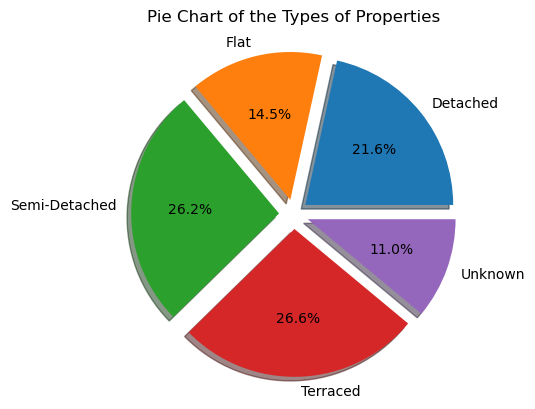

In [13]:
plt.title('Pie Chart of the Types of Properties')
plt.pie(counts, labels = labels, explode = [.1, .1, .1, .1, .1], shadow = True, autopct = '%1.1f%%')
plt.show() 

From the pie chart, we could see that this is an imbalanced dataset. 

## Load the Image Data
Specify the directory, the sizes of images, the number of images to be loaded in one batch, and the random seed. The seed is a random integer ranging from $1$ to $2^{32} - 1$, the largest number that Kaggle could store. The purpose of setting such a random seed is to ensure that for each time, the dataset is being split randomly.

From this step, the images related to the `Unknown` class of property types are removed.

In [14]:
directory = '/kaggle/input/dissertation-1-data/Files/street_view/'

height = 64
width = 64
batch = 32
seed = random.randint(1, np.power(2, 32) - 1)

## Train-Validation-Test Split
Split the dataset into training, validation, and testing sets. The proportions of them are $70\%$, $20\%$, and $10\%$. Split the training and validation sets first on a $70$-$30$ basis, and split the validation set on a $20$-$10$ basis by using `skip` and `take`. `Cache` and `Prefetch` methods are applied to save runtime and memory. One hot encoder for the labels are introduced by setting `label_mode = 'categorical'`.

In [15]:
tr_val = image_dataset_from_directory(
  directory,
  validation_split = .3,
  subset = 'both',
  seed = seed,
  image_size = (height, width),
  batch_size = batch,
  label_mode = 'categorical')

training = tr_val[0].cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation = tr_val[1].cache().prefetch(buffer_size = tf.data.AUTOTUNE)

val_bat = tf.data.experimental.cardinality(validation)
validation = validation.skip((2 * val_bat) // 3).cache().prefetch(buffer_size = tf.data.AUTOTUNE)
testing = validation.take((2 * val_bat) // 3).cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Found 13775 files belonging to 4 classes.
Using 9643 files for training.
Using 4132 files for validation.


## Model Components Settings
The actual types of properties in the training and testing sets are extracted first, and the labels specify the $4$ types of properties. They are `detached`, `flat`, `semi-detached`, and `terraced`.

In [16]:
propertyType_train_fac = np.argmax(np.asarray(list(training.unbatch().map(lambda x, y: y))), axis = 1)
propertyType_test_fac = np.argmax(np.asarray(list(testing.unbatch().map(lambda x, y: y))), axis = 1)
labels = pd.Series(propertyType_train_fac).astype('category')

### Assign Class Weights to the Categorical Cross Entropy Loss Function
In our models, categorical cross entropy loss is applied. Since the dataset is imbalanced, the class weights should be taken into account. They are calculated as follows. For each class, the product of the number of classes and the number of samples in this class is calculated at first. The weight for this class is represented by the ratio between the total number of samples and the product mentioned above.

In [17]:
loss = losses.CategoricalCrossentropy()
weights = sum(labels.value_counts()) / (labels.value_counts(sort = False) * len(labels.cat.categories))
loss.weighted = weights

### Allow Callbacks to Monitor the Models

The models should be terminated from training when the validation accuracy is not getting any higher for 5 epochs.

The learning rate has an initial value of $5 \times 10 ^ {-4}$. Every time the validation accuracy decreases, or when it fails to reach the highest value in previous epochs, the learning rate is multiplied by $4 \times 10 ^ {-2}$.

In [18]:
lr = 5e-4
Callbacks = [
             EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 5, restore_best_weights = True), 
             ReduceLROnPlateau(monitor = 'val_accuracy', factor = 4e-2, patience = 0, cooldown = 0)
            ]

### Visualising Model Accuracy and Model Loss

In [19]:
def visualise_accuracy_loss(history):
    
    '''
    This function takes the training and validation results of a Keras sequential model as an input, 
    and sketches 2 plots showing the model accuracy and model loss.
    '''
    
    # extract training and validation accuracy
    ac = history.history['accuracy']
    val_ac = history.history['val_accuracy']

    # extract training and validation loss
    lo = history.history['loss']
    val_lo = history.history['val_loss']
    
    # a series of epochs
    epoch = len(ac)
    epoch_vec = np.arange(epoch) + 1

    # plot model accuracy
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_vec, ac, label = 'Training Accuracy')
    plt.plot(epoch_vec, val_ac, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Model Accuracy')

    # plot model loss
    plt.subplot(1, 2, 2)
    plt.plot(epoch_vec, lo, label = 'Training Loss')
    plt.plot(epoch_vec, val_lo, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Model Loss')
    plt.show()

## Modelling
Since the components of the models have been set up, we are able to build models.

### Multi-Layer Perceptron Model

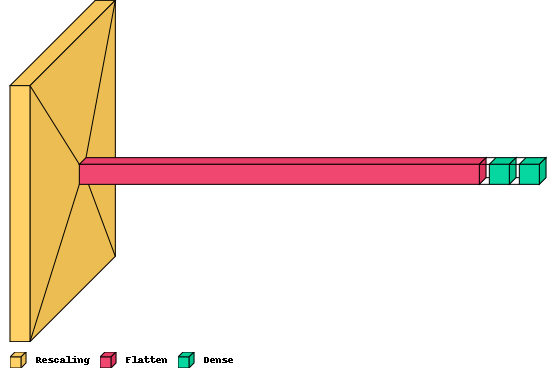

In [20]:
mlp = Sequential([
                  Rescaling(1. / 255, input_shape = (height, width, 3)), # normalise the pixel values
                  Flatten(), # reshape them into a vector
                  Dense(160, activation = tf.nn.leaky_relu), # fully connected layer with 160 neurons, uses leaky relu 
                  Dense( # output layer, 4 neurons, uses softmax, L1-regularisation techniques applied
                        len(labels.cat.categories), 
                        activation = tf.nn.softmax, 
                        kernel_initializer = initializers.RandomNormal(),
                        bias_initializer = initializers.Zeros(),
                        kernel_regularizer = regularizers.L1(1e-5),
                        bias_regularizer = regularizers.L1(10),
                        activity_regularizer = regularizers.L1(10)
                       )
                ])
# uses weighted loss, adam optimiser, and accuracy as evaluation metric
mlp.compile(loss = loss, optimizer = optimizers.Adam(learning_rate = lr), metrics = ['accuracy'])
# visualise the layers
visualkeras.layered_view(mlp, legend = True)

Show the structure of the model.

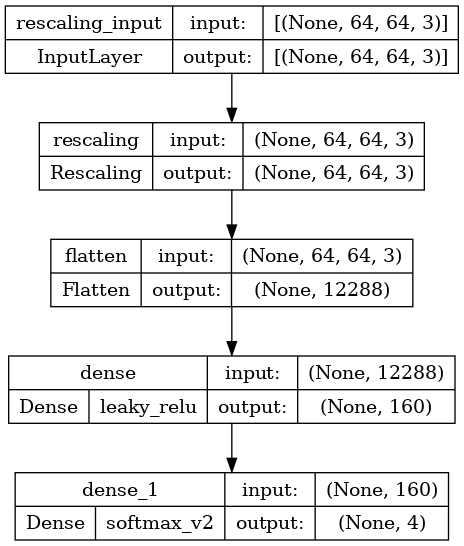

In [21]:
plot_model(mlp, show_shapes = True, show_layer_names = True, show_layer_activations = True)

Train and validate the model. Visualise the accuracy and loss.

Epoch 1/60
302/302 [==============================] - 3s 5ms/step - loss: 11.4489 - accuracy: 0.3252 - val_loss: 11.3019 - val_accuracy: 0.3638 - lr: 5.0000e-04
Epoch 2/60
302/302 [==============================] - 1s 4ms/step - loss: 11.3413 - accuracy: 0.3646 - val_loss: 11.3113 - val_accuracy: 0.3993 - lr: 5.0000e-04
Epoch 3/60
302/302 [==============================] - 1s 4ms/step - loss: 11.3129 - accuracy: 0.3818 - val_loss: 11.3468 - val_accuracy: 0.3804 - lr: 5.0000e-04
Epoch 4/60
302/302 [==============================] - 1s 4ms/step - loss: 11.2226 - accuracy: 0.4417 - val_loss: 11.2526 - val_accuracy: 0.4123 - lr: 2.0000e-05
Epoch 5/60
302/302 [==============================] - 1s 4ms/step - loss: 11.2180 - accuracy: 0.4494 - val_loss: 11.2523 - val_accuracy: 0.4094 - lr: 2.0000e-05
Epoch 6/60
302/302 [==============================] - 1s 4ms/step - loss: 11.2149 - accuracy: 0.4466 - val_loss: 11.2501 - val_accuracy: 0.4203 - lr: 8.0000e-07
Epoch 7/60
302/302 [==============

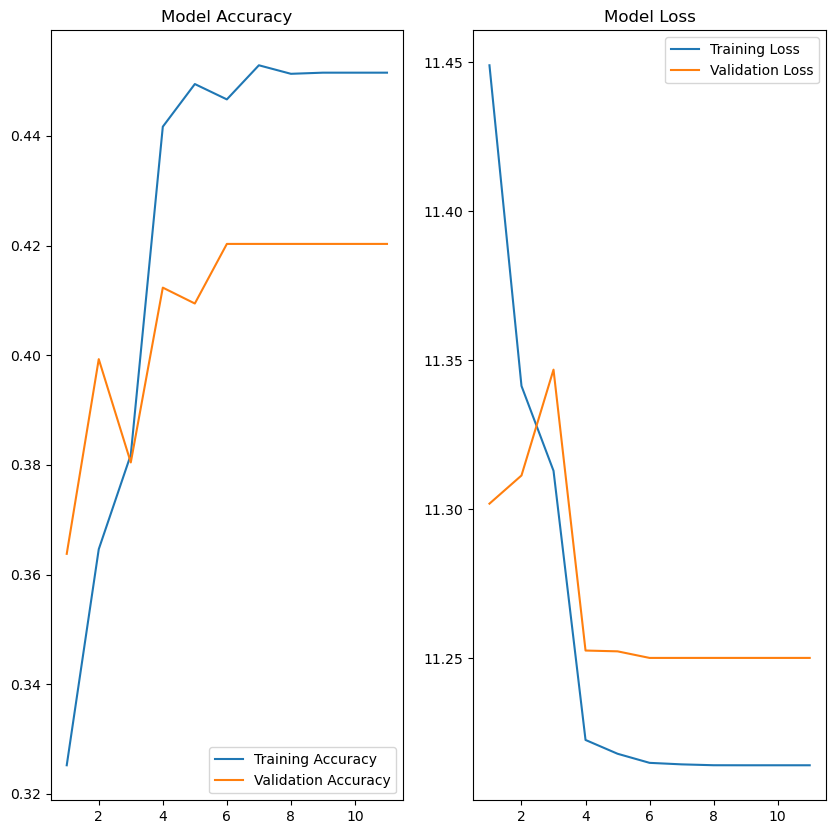

In [22]:
history = mlp.fit(training, validation_data = validation, epochs = 60, batch_size = 50, callbacks = Callbacks)
visualise_accuracy_loss(history)

Calculate the confusion matrix of the property type in the testing set, and visualise it using a heat map.

44/44 [==============================] - 0s 2ms/step


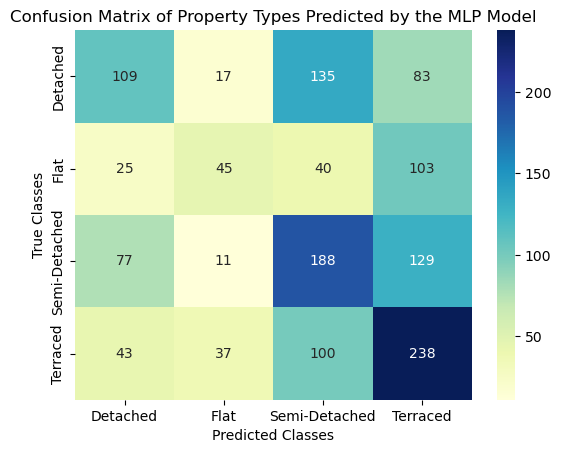

In [23]:
propertyType_test_pred_MLP = np.argmax(mlp.predict(testing), axis = 1)
label_names = ['Detached', 'Flat', 'Semi-Detached', 'Terraced']
confmat_MLP = pd.DataFrame(confusion_matrix(propertyType_test_fac, propertyType_test_pred_MLP))

ax = plt.axes()
sns.heatmap(confmat_MLP, annot = True, 
            cmap = 'YlGnBu', fmt = 'g', 
            cbar = True, xticklabels = label_names, 
            yticklabels = label_names, ax = ax)  
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
ax.set_title('Confusion Matrix of Property Types Predicted by the MLP Model')
plt.show()

Report necessary classification results in the testing set.

In [24]:
print(
      classification_report(
                      propertyType_test_fac, 
                      propertyType_test_pred_MLP, 
                      target_names = label_names
      )
)

               precision    recall  f1-score   support

     Detached       0.43      0.32      0.36       344
         Flat       0.41      0.21      0.28       213
Semi-Detached       0.41      0.46      0.43       405
     Terraced       0.43      0.57      0.49       418

     accuracy                           0.42      1380
    macro avg       0.42      0.39      0.39      1380
 weighted avg       0.42      0.42      0.41      1380



### Convolutional Neural Network Model

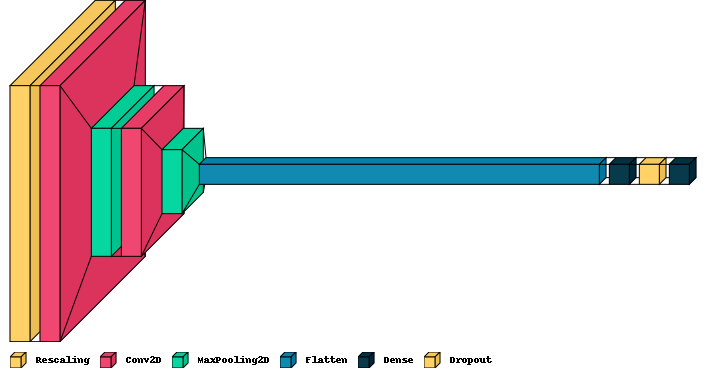

In [25]:
cnn = Sequential([
                  Rescaling(1. / 255, input_shape = (height, width, 3)), # normalise the image data
                  Conv2D(50, 4, padding = 'same', activation = tf.nn.leaky_relu), # convolutional layer, uses leaky relu
                  MaxPooling2D(pool_size = (2, 2)), # 2 by 2 max pooling
                  Conv2D(48, 4, padding = 'same', activation = tf.nn.leaky_relu), # convolutional layer, uses leaky relu
                  MaxPooling2D(pool_size = (2, 2)), # 2 by 2 max pooling
                  Flatten(), # flatten the matrix
                  Dense(42, activation = tf.nn.leaky_relu), # fully connected layer, uses leaky relu
                  Dropout(.25), # dropping out neurons in order to avoid overfitting
                  Dense( # output layer, 4 neurons, uses softmax, L1-regularisation techniques applied
                        len(labels.cat.categories), 
                        activation = tf.nn.softmax, 
                        kernel_initializer = initializers.RandomNormal(),
                        bias_initializer = initializers.Zeros(),
                        kernel_regularizer = regularizers.L1(1e-5),
                        bias_regularizer = regularizers.L1(10),
                        activity_regularizer = regularizers.L1(10)
                       )
                ])
# uses weighted loss, adam optimiser, and accuracy as evaluation metric
cnn.compile(loss = loss, optimizer = optimizers.Adam(learning_rate = lr), metrics = ['accuracy'])
# visualise the layers
visualkeras.layered_view(cnn, legend = True)

Show the structure of the model.

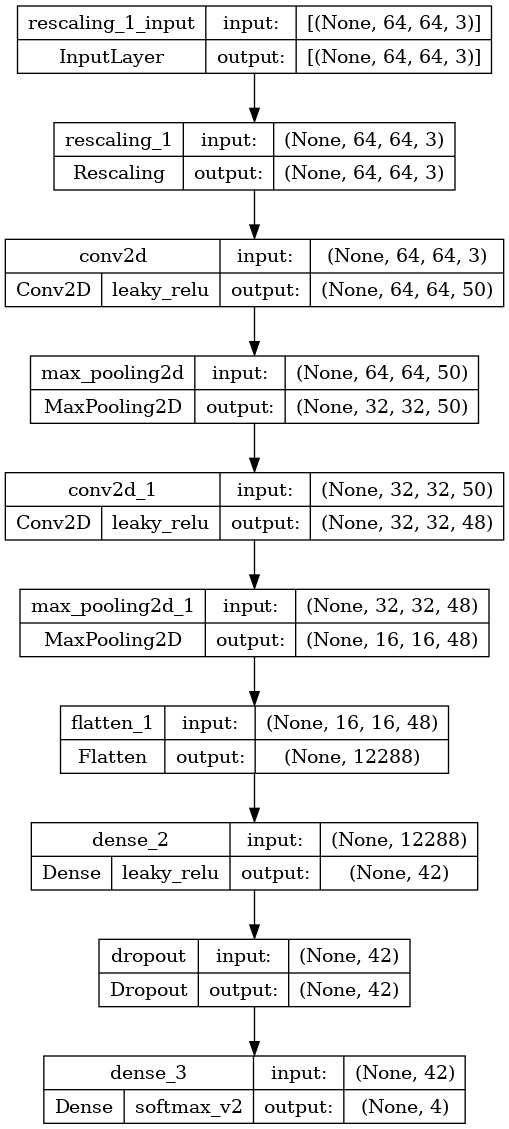

In [26]:
plot_model(cnn, to_file = 'cnn.png', show_shapes = True, show_layer_names = True, show_layer_activations = True)

Train and validate the model. Visualise the accuracy and loss.

Epoch 1/60
302/302 [==============================] - 5s 9ms/step - loss: 11.3094 - accuracy: 0.3608 - val_loss: 11.2560 - val_accuracy: 0.3978 - lr: 5.0000e-04
Epoch 2/60
302/302 [==============================] - 3s 8ms/step - loss: 11.2521 - accuracy: 0.4144 - val_loss: 11.2198 - val_accuracy: 0.4435 - lr: 5.0000e-04
Epoch 3/60
302/302 [==============================] - 2s 8ms/step - loss: 11.2266 - accuracy: 0.4382 - val_loss: 11.2142 - val_accuracy: 0.4333 - lr: 5.0000e-04
Epoch 4/60
302/302 [==============================] - 3s 8ms/step - loss: 11.1856 - accuracy: 0.4592 - val_loss: 11.2025 - val_accuracy: 0.4616 - lr: 2.0000e-05
Epoch 5/60
302/302 [==============================] - 3s 8ms/step - loss: 11.1800 - accuracy: 0.4671 - val_loss: 11.2018 - val_accuracy: 0.4667 - lr: 2.0000e-05
Epoch 6/60
302/302 [==============================] - 3s 8ms/step - loss: 11.1758 - accuracy: 0.4679 - val_loss: 11.1995 - val_accuracy: 0.4594 - lr: 2.0000e-05
Epoch 7/60
302/302 [==============

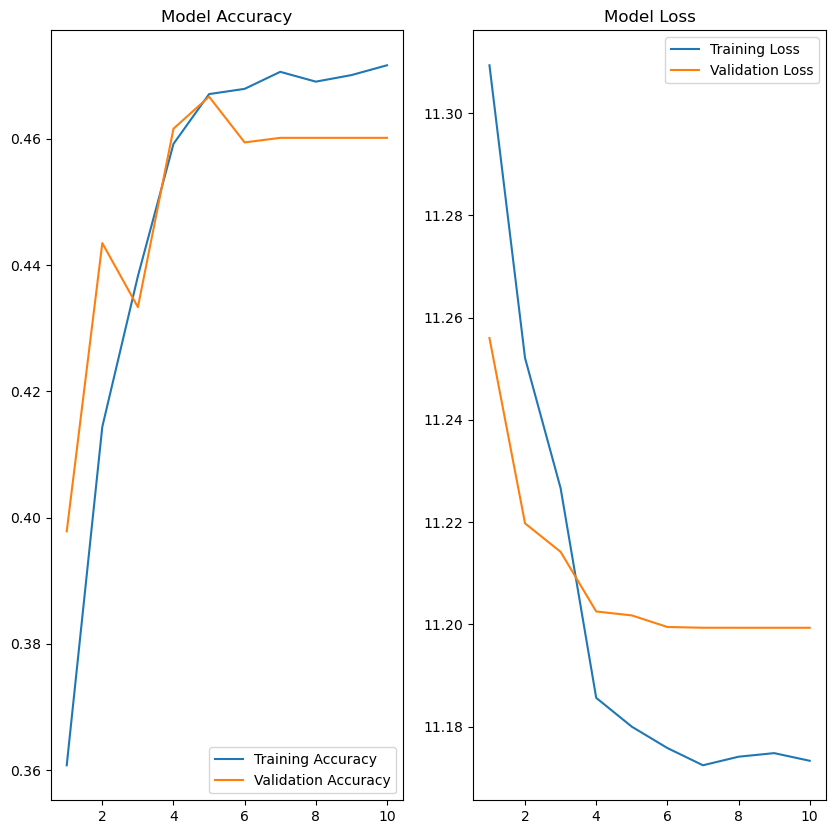

In [27]:
history = cnn.fit(training, validation_data = validation, epochs = 60, batch_size = 50, callbacks = Callbacks)
visualise_accuracy_loss(history)

Calculate the confusion matrix of the property type in the testing set, and visualise it using a heat map.

44/44 [==============================] - 0s 3ms/step


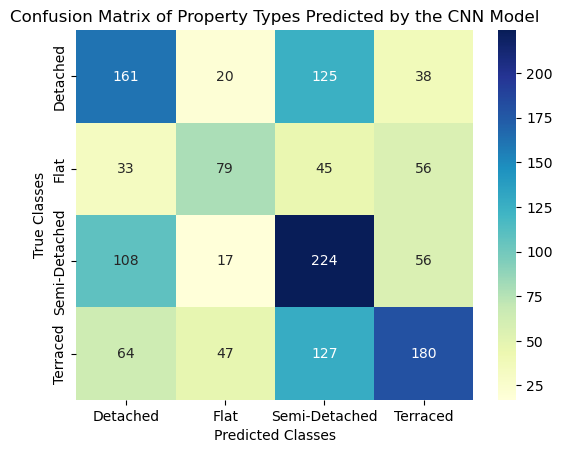

In [28]:
propertyType_test_pred_CNN = np.argmax(cnn.predict(testing), axis = 1)
confmat_CNN = confusion_matrix(propertyType_test_fac, propertyType_test_pred_CNN)

ax = plt.axes()
sns.heatmap(confmat_CNN, annot = True, 
            cmap = 'YlGnBu', fmt = 'g', 
            cbar = True, xticklabels = label_names, 
            yticklabels = label_names, ax = ax)  
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
ax.set_title('Confusion Matrix of Property Types Predicted by the CNN Model')
plt.show()

Report necessary classification results in the testing set.

In [29]:
print(
      classification_report(
                      propertyType_test_fac, 
                      propertyType_test_pred_CNN, 
                      target_names = label_names
      )
)

               precision    recall  f1-score   support

     Detached       0.44      0.47      0.45       344
         Flat       0.48      0.37      0.42       213
Semi-Detached       0.43      0.55      0.48       405
     Terraced       0.55      0.43      0.48       418

     accuracy                           0.47      1380
    macro avg       0.47      0.46      0.46      1380
 weighted avg       0.48      0.47      0.47      1380

